In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import skew, kurtosis, jarque_bera

sns.set_theme()

In [8]:
aapl = yf.download('AAPL',
                   start= '2020-01-01',
                   end = '2025-05-01')

[*********************100%***********************]  1 of 1 completed


In [9]:
aapl.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620834,72.681281,71.373211,71.627084,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307495,73.609729,71.849518,71.849518,132079200


<Axes: xlabel='Date'>

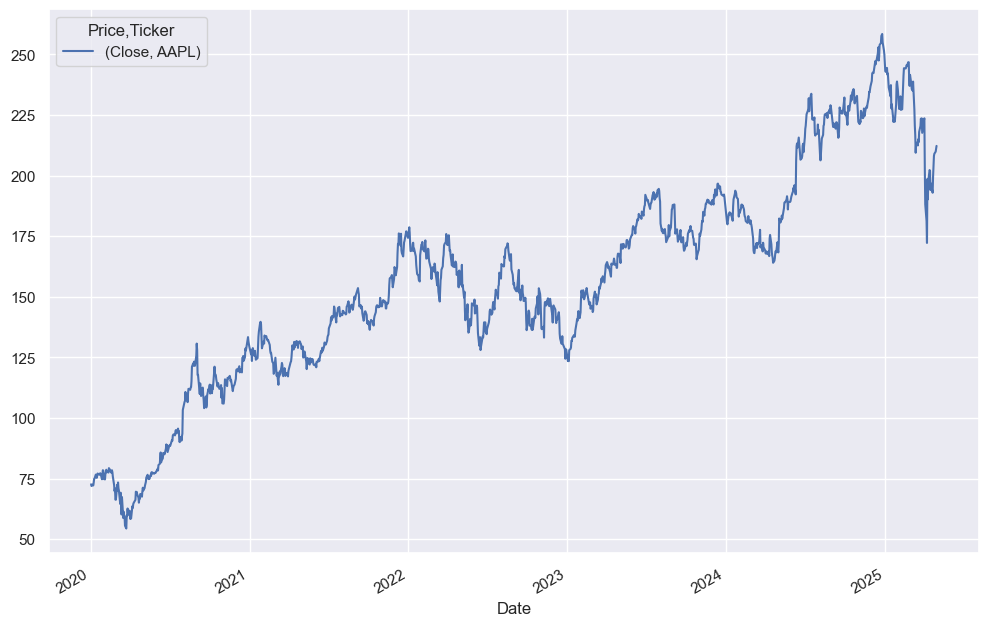

In [10]:
aapl[[('Close', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

In [15]:
close_values = aapl[[('Close', 'AAPL')]]
aapl[('log_returns', 'AAPL')] = np.log(close_values / close_values.shift(1))
aapl.dropna(inplace = True)

<Axes: xlabel='Date'>

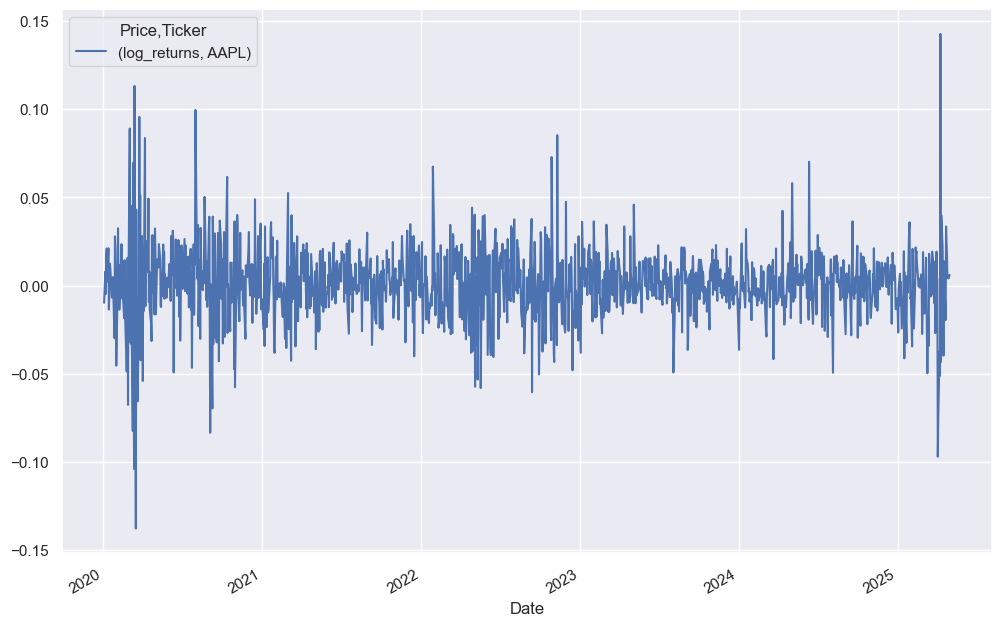

In [16]:
aapl[[('log_returns', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import optuna

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
df = df[["Close"]]  # keep only the closing price


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Create lagged features
for lag in [1, 2, 3, 4]:
    df[f"lag_{lag}"] = df["Close"].shift(lag)

# Create difference features
df["diff_1"] = df["Close"].diff(1)

# Drop rows with NaN values created by shifting
df.dropna(inplace=True)

# Define features X and target y
X = df.drop("Close", axis=1).values
y = df["Close"].values

In [4]:
tscv = TimeSeriesSplit(n_splits=5)

In [5]:
svr = SVR()  # defaults: kernel='rbf', C=1.0, gamma='scale'

In [6]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
    "epsilon": [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(X, y)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [7]:
best_svr = grid_search.best_estimator_

# Example: Split out the last 20% of data as test
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Refit on training portion
best_svr.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")


Test MSE: 3.1260
Test R²:  0.9736


c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


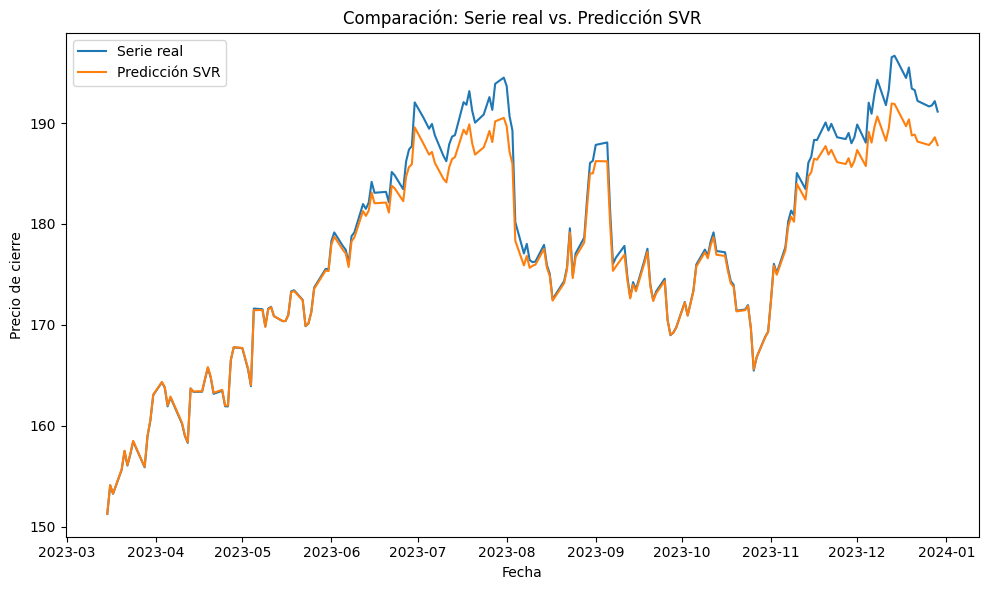

In [8]:
dates_test = df.index[split_index:]

plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_test,      label="Serie real")
plt.plot(dates_test, y_pred,      label="Predicción SVR")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.title("Comparación: Serie real vs. Predicción SVR")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 3. Función objetivo para Optuna
def objective(trial):
    # 3.1. Sugerencia de hiperparámetros
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "poly", "sigmoid"])
    C      = trial.suggest_loguniform("C", 1e-2, 1e2)
    gamma  = trial.suggest_categorical("gamma", ["scale", "auto"])
    epsilon= trial.suggest_loguniform("epsilon", 1e-3, 1e0)
    degree = trial.suggest_int("degree", 2, 4)  # solo importa si kernel="poly"
    
    # 3.2. Para cada split, entrenamos y validamos
    mses = []
    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model = SVR(kernel=kernel,
                    C=C,
                    gamma=gamma,
                    epsilon=epsilon,
                    degree=degree)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_val, y_pred))
    
    # 3.3. Retornamos el MSE promedio (Optuna minimiza la función objetivo)
    return np.mean(mses)

# 4. Lanzamos el estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

# 5. Resultados
print("Mejores hiperparámetros:")
for key, val in study.best_params.items():
    print(f"  - {key}: {val}")
print(f"Mejor MSE en CV: {study.best_value:.4f}")

[I 2025-05-15 17:19:05,811] A new study created in memory with name: no-name-31ebcd9b-98d1-4357-beae-54cd347b9f95
C:\Users\dfdop\AppData\Local\Temp\ipykernel_27836\2404785631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C      = trial.suggest_loguniform("C", 1e-2, 1e2)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_27836\2404785631.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon= trial.suggest_loguniform("epsilon", 1e-3, 1e0)
c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[*********************100%***********************]  1 of 1 completed
[I 2025-05-15 20:13:01,173] A new study created in memory with name: no-name-b0a7c3f8-0844-4c01-a95b-8415184902e2
C:\Users\dfdop\AppData\Local\Temp\ipykernel_27212\2785484188.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C       = trial.suggest_loguniform("C", 1e-2, 1e2)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_27212\2785484188.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1.0)
c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was

Mejores hiperparámetros: {'C': 0.047816656332998274, 'gamma': 'scale', 'epsilon': 0.0010177341275519327}
Mejor MSE: 1.5489441747944089e-07


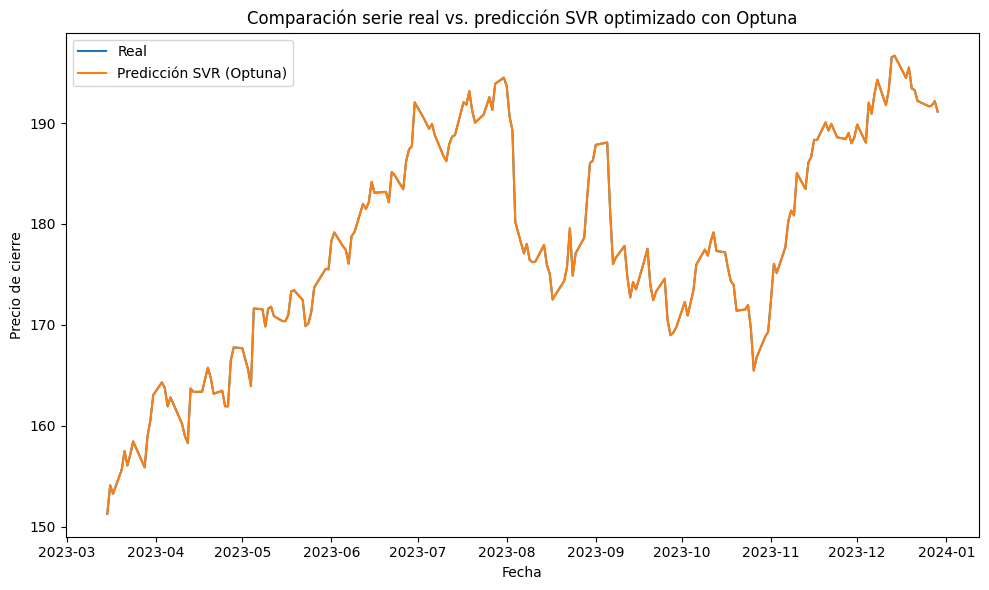

In [11]:
# 1. Descargar los datos
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")[["Close"]]
# 2. Crear features de lag
for lag in [1, 2]:
    df[f"lag_{lag}"] = df["Close"].shift(lag)
    df[f"diff_{lag}"] = df["Close"].diff(lag)


df.dropna(inplace=True)

X = df.drop("Close", axis=1).values
y = df["Close"].values

# 3. Definir splitter de series de tiempo
tscv = TimeSeriesSplit(n_splits=5)

# 4. Función objetivo para Optuna
def objective(trial):
    # Sugerencia de hiperparámetros
    C       = trial.suggest_loguniform("C", 1e-2, 1e2)
    gamma   = trial.suggest_categorical("gamma", ["scale", "auto"])
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1.0)
    
    model = SVR(kernel="linear", C=C, gamma=gamma, epsilon=epsilon)
    
    # Validación cruzada temporal
    mses = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        mses.append(mean_squared_error(y_val, preds))
    
    # Retornamos el MSE promedio (Optuna maximiza por defecto, así que usamos negativo)
    return np.mean(mses)

# 5. Crear y ejecutar el estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

print("Mejores hiperparámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

# 6. Ajustar el modelo final con los mejores parámetros
best_params = study.best_params
best_svr = SVR(kernel="linear", **best_params)

# Reentrenamos con toda la muestra de entrenamiento (p.ej., 80%)
split = int(len(X)*0.8)
best_svr.fit(X[:split], y[:split])

# Predecimos sobre el conjunto de prueba
y_pred = best_svr.predict(X[split:])
y_test = y[split:]
dates_test = df.index[split:]

plt.figure(figsize=(10,6))
plt.plot(dates_test, y_test,  label="Real")
plt.plot(dates_test, y_pred,  label="Predicción SVR (Optuna)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.title("Comparación serie real vs. predicción SVR optimizado con Optuna")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Supongamos X_train, y_train, X_test ya definidos y ajustamos SVR
svr = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)
svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)
residuals = y_train - y_train_pred  # Calcular residuos

B = 1000  # Número de réplicas
T = len(X_test)
boot_preds = np.zeros((B, T))

for b in range(B):
    # Remuestrear residuos con reemplazo
    sampled_res = np.random.choice(residuals, size=len(residuals), replace=True)
    # Generar serie sintética en entrenamiento
    y_train_star = y_train_pred + sampled_res
    # Opcional: reajustar el modelo en y_train_star
    svr.fit(X_train, y_train_star)
    # Predecir para test
    boot_preds[b, :] = svr.predict(X_test)

# Cálculo de percentiles para cada instante t
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds, 97.5, axis=0)
y_pred = svr.predict(X_test)  # Predicción central

# Gráfica
import matplotlib.pyplot as plt

dates = df.index[split_index:]
plt.figure(figsize=(10,6))
plt.plot(dates, y_test, label='Real')
plt.plot(dates, y_pred, label='Predicción SVR')
plt.fill_between(dates, lower, upper, color='gray', alpha=0.3, label='Banda 95%')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.title('Serie real, predicción SVR y bandas de confianza (bootstrap)')
plt.tight_layout()
plt.show()


NameError: name 'X_train' is not defined

In [14]:
# 1. Instalación de dependencias (solo si no las tienes)
# !pip install yfinance xgboost scikit-learn

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 2. Descarga de datos: serie de precios de cierre de Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-12-31', progress=False)
# Nos quedamos solo con el precio de cierre
df = data[['Close']].copy()

# 3. Feature engineering: creamos rezagos y medias móviles
def create_features(df, lags=[1,2,3,5], windows=[5,10,20]):
    for lag in lags:
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    for w in windows:
        df[f'roll_mean_{w}'] = df['Close'].shift(1).rolling(window=w).mean()
    df.dropna(inplace=True)
    return df

df_fe = create_features(df)

# 4. Definir variables X e y
X = df_fe.drop(columns=['Close'])
y = df_fe['Close']

# 5. Preparar validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)

# 6. Definir el modelo y la rejilla de búsqueda
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# 7. Ajuste del modelo
grid.fit(X, y)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor RMSE (CV):", -grid.best_score_)

# 8. Evaluación final sobre el último pliegue
#    opcional: volver a entrenar sobre todo el training set y validar en hold-out
X_train, X_test = X.iloc[:-int(0.2*len(X))], X.iloc[-int(0.2*len(X)):]
y_train, y_test = y.iloc[:-int(0.2*len(y))], y.iloc[-int(0.2*len(y)):]

best = grid.best_estimator_
best.fit(X_train, y_train)
preds = best.predict(X_test)
rmse_test = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE en hold-out: {rmse_test:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Mejor RMSE (CV): 20.461545562744142


TypeError: got an unexpected keyword argument 'squared'